<a target="_blank" href="https://colab.research.google.com/github/piavik/Prognosis/blob/dev/experiments/EDA_RandForest.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Прогнозування Відтоку Клієнтів для Телекомунікаційної компанії

# Вступ
ви влаштувались на першу роботу в IT на позицію Data Scientist. Ваш керівник вирішив дати вам невеличкий проєкт, щоб ви ознайомились з базою даних клієнтів, видами сервісів, які надає компанія і технічними можливостями компанії.
Цей документ описує технічне завдання проєкту, метою якого є розробка прогностичної моделі для ідентифікації ймовірності припинення клієнтами користування телекомунікаційними послугами на основі історичних даних про клієнтів. Проєкт передбачає використання аналізу даних, перед обробки даних, машинного навчання, оцінки моделей, а також пакування моделі у контейнер для забезпечення відтворюваності.

## Опис Даних
Надається набір даних, який включає інформацію про клієнтів телекомунікаційної компанії: демографічні характеристики, історію використання послуг, тарифні плани, дані про відток(Churn).

## Завантаження і ініціалізація

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
GDRIVE_URL='https://drive.usercontent.google.com/u/0/uc?id='
FILE_ID='121xd_NVxBIiDevkqnNUDpDdwj8jcR41D'
CSV_DATA_PATH  = Path('../datasets').absolute()
CSV_DATA_PATH.mkdir(exist_ok=True)
FILENAME = "internet_service_churn.csv"
zipfilename = "archive.zip"

PROJECT_NAME = "Prognosis"

SEED = 42

In [5]:
# встановлення модуля для вимірюання часу виконання тільки в Colab середовищі
# завантеження файлу з даними і розархівування
# підготовка папки для зберігання
if os.getenv("COLAB_RELEASE_TAG") == None:
  print('it is not colab')
  import shutil
  import requests
  from zipfile import ZipFile
  file_url = f"{GDRIVE_URL}{FILE_ID}"
  req = requests.get(file_url, allow_redirects=True, stream=True)
  with open(zipfilename, 'wb') as fd:
    for chunk in req.iter_content(chunk_size=128):
      fd.write(chunk)
  with ZipFile(zipfilename, 'r') as zip_file:
       zip_file.extractall(CSV_DATA_PATH)
  os.remove(zipfilename)
  MODELS_PATH = Path(f'../models').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

else:
  print('it is colab environment, proceeding with install ...')
  !pip install -q ipython-autotime
  !gdown $FILE_ID
  !unzip -oq $zipfilename -d $CSV_DATA_PATH

  from google.colab import drive
  drive.mount('/content/gdrive')

  MODELS_PATH = Path(f'/content/gdrive/MyDrive/Colab Notebooks/{PROJECT_NAME}').absolute()
  MODELS_PATH.mkdir(exist_ok=True)

  %load_ext autotime

it is colab environment, proceeding with install ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=121xd_NVxBIiDevkqnNUDpDdwj8jcR41D
To: /content/archive.zip
100% 782k/782k [00:00<00:00, 111MB/s]
Mounted at /content/gdrive
time: 428 µs (started: 2024-10-18 16:15:36 +00:00)


In [6]:
# створення датасету з файлу
df = pd.read_csv(CSV_DATA_PATH/FILENAME)

time: 105 ms (started: 2024-10-18 16:15:36 +00:00)


In [7]:
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


time: 97.8 ms (started: 2024-10-18 16:15:36 +00:00)


# Аналіз Даних (EDA)
* Використання бібліотек: Pandas, Matplotlib, Seaborn.
* Основні завдання: Вивчення розподілів, виявлення відсутніх значень, аналіз кореляцій.


## Первинний аналіз

In [8]:
# інформація про датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB
time: 22.7 ms (started: 2024-10-18 16:15:37 +00:00)


In [9]:
# перевіряємо на пусті значення
df.isnull().sum(axis=0)

,0
id,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,21572
service_failure_count,0
download_avg,381
upload_avg,381
download_over_limit,0


time: 9.33 ms (started: 2024-10-18 16:15:37 +00:00)


In [10]:
# Перевірка на дублікати
df.duplicated().sum()

0

time: 38.3 ms (started: 2024-10-18 16:15:37 +00:00)


In [11]:
# колонка id для подальшого аналізу не потрібна 0 видаляємо
df.drop(columns='id', inplace =True)

time: 6.54 ms (started: 2024-10-18 16:15:37 +00:00)


In [12]:
df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,0,0,6.39,0,NaN,0,0.0,0.0,0,1


time: 92.7 ms (started: 2024-10-18 16:15:37 +00:00)


In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,72274.0,0.815259,0.388090,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,72274.0,0.334629,0.471864,0.00,0.00,0.00,1.00,1.00
subscription_age,72274.0,2.450051,2.034990,-0.02,0.93,1.98,3.30,12.80
bill_avg,72274.0,18.942483,13.215386,0.00,13.00,19.00,22.00,406.00
reamining_contract,50702.0,0.716039,0.697102,0.00,0.00,0.57,1.31,2.92
service_failure_count,72274.0,0.274234,0.816621,0.00,0.00,0.00,0.00,19.00
download_avg,71893.0,43.689911,63.405963,0.00,6.70,27.80,60.50,4415.20
upload_avg,71893.0,4.192076,9.818896,0.00,0.50,2.10,4.80,453.30
download_over_limit,72274.0,0.207613,0.997123,0.00,0.00,0.00,0.00,7.00
churn,72274.0,0.554141,0.497064,0.00,0.00,1.00,1.00,1.00


time: 389 ms (started: 2024-10-18 16:15:37 +00:00)


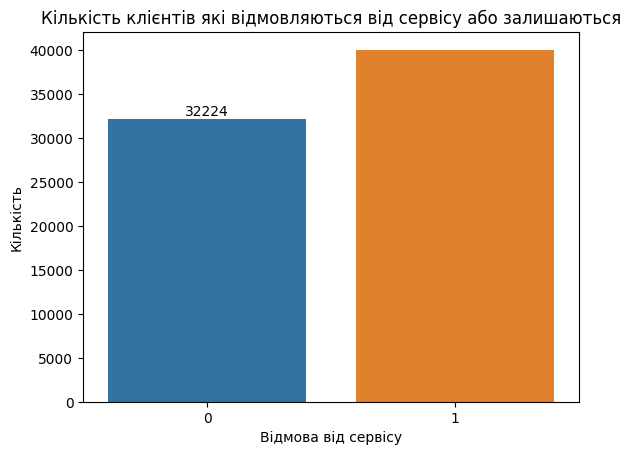

time: 1.35 s (started: 2024-10-18 16:15:37 +00:00)


In [14]:
plt.title("Кількість клієнтів які відмовляються від сервісу або залишаються")
ax = sns.countplot(x='churn', data=df, palette="tab10")
ax.set(xlabel="Відмова від сервісу", ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

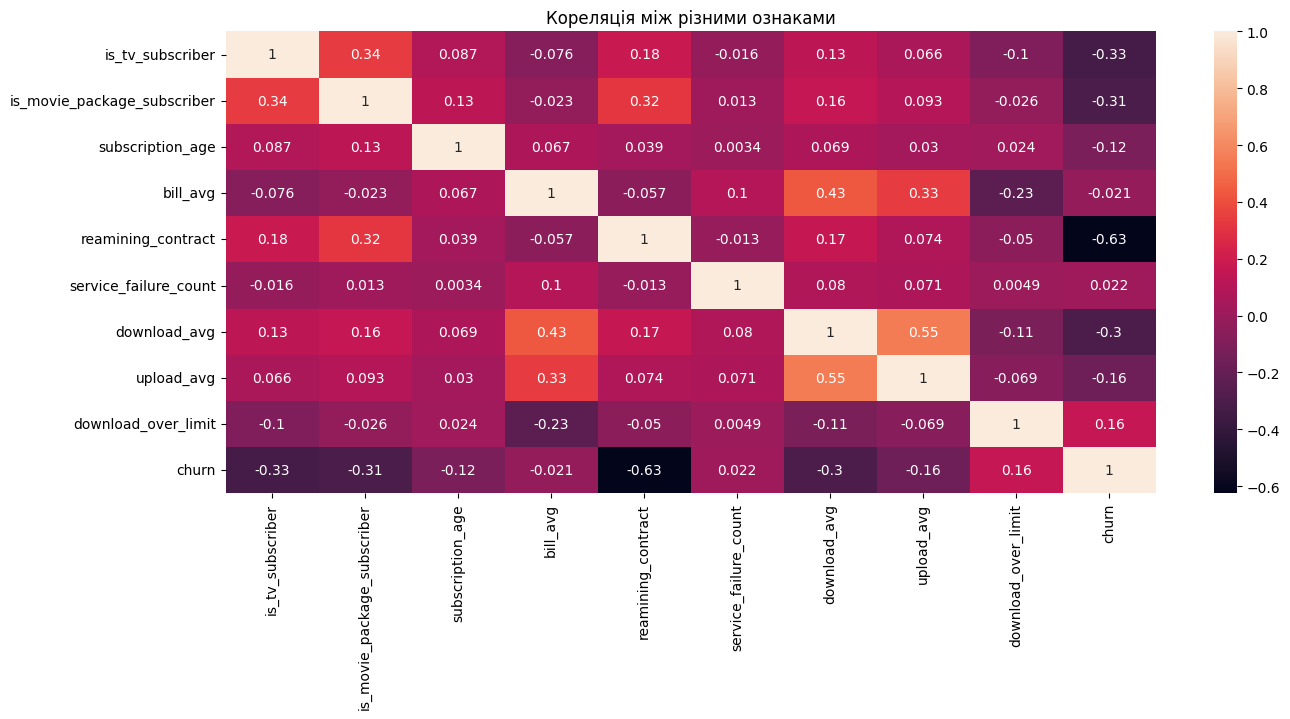

time: 2.06 s (started: 2024-10-18 16:15:39 +00:00)


In [15]:
plt.figure(figsize=(15,6))
ax = sns.heatmap(df.corr(), annot=True)
plt.title("Кореляція між різними ознаками")
plt.show()

### Висновок

Найбільша кореліція відтоку (churn) спостерігається з наступними ознаками:
* reamining_contract (сильно, негативно)
* is_tv_subscriber (слабо, негативно)
* is_movie_package_subscriber (слабо, негативно)
* download_avg (слабо, негативно)

## Аналіз пустих даних

In [16]:
df.isnull().sum(axis=0)

,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,21572
service_failure_count,0
download_avg,381
upload_avg,381
download_over_limit,0
churn,0


time: 17.6 ms (started: 2024-10-18 16:15:41 +00:00)


In [17]:
# вибираємо дані, де reamining_contract = 0
zero_contract_df = df[df['reamining_contract'] == 0]

time: 2.84 ms (started: 2024-10-18 16:15:41 +00:00)


In [18]:
zero_contract_df.shape

(16363, 10)

time: 3.88 ms (started: 2024-10-18 16:15:41 +00:00)


In [19]:
# вибираємо дані, де reamining_contract відсутннє
no_contract_df = df[df['reamining_contract'].isnull()]

time: 7.31 ms (started: 2024-10-18 16:15:41 +00:00)


In [20]:
no_contract_df.shape

(21572, 10)

time: 9.8 ms (started: 2024-10-18 16:15:41 +00:00)


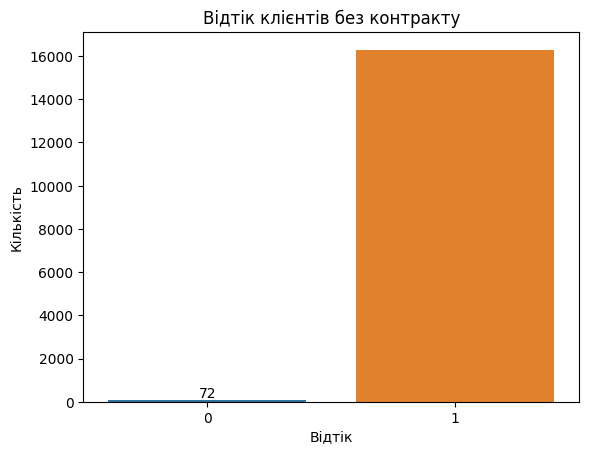

churn
1    16291
0       72
Name: count, dtype: int64
time: 1.12 s (started: 2024-10-18 16:15:41 +00:00)


In [21]:
plt.title("Відтік клієнтів без контракту")
ax = sns.countplot(x='churn', data=zero_contract_df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()
print(zero_contract_df['churn'].value_counts())

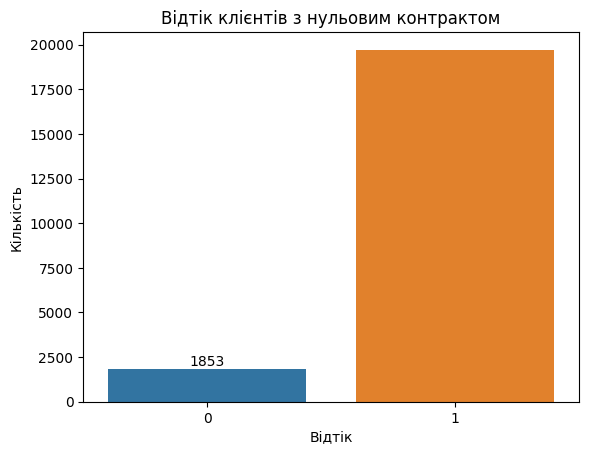

churn
1    19719
0     1853
Name: count, dtype: int64
time: 1.47 s (started: 2024-10-18 16:15:42 +00:00)


In [22]:
plt.title("Відтік клієнтів з нульовим контрактом")
ax = sns.countplot(x='churn', data=no_contract_df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()
print(no_contract_df['churn'].value_counts())

### Висновок

* Дані в стовпчику "reamining_contract" сильно впливають на значення відтоку ('churn').
* При цьому відсутність даних і нульове значення впливають приблизно однакомо, тому відсутні значення можна замінити на 0.
* Пустими значеннями для download_avg та upload_avg можна знехтувати.

In [23]:
df["reamining_contract"] = df["reamining_contract"].replace(np.nan, 0.0)

time: 10.5 ms (started: 2024-10-18 16:15:43 +00:00)


Пустими значеннями для download_avg та upload_avg можна знехтувати.

In [24]:
df.dropna(inplace=True)

time: 30.4 ms (started: 2024-10-18 16:15:43 +00:00)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71893 entries, 0 to 72273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             71893 non-null  int64  
 1   is_movie_package_subscriber  71893 non-null  int64  
 2   subscription_age             71893 non-null  float64
 3   bill_avg                     71893 non-null  int64  
 4   reamining_contract           71893 non-null  float64
 5   service_failure_count        71893 non-null  int64  
 6   download_avg                 71893 non-null  float64
 7   upload_avg                   71893 non-null  float64
 8   download_over_limit          71893 non-null  int64  
 9   churn                        71893 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 6.0 MB
time: 35.7 ms (started: 2024-10-18 16:15:43 +00:00)


In [26]:
df.isnull().sum(axis = 0)

,0
is_tv_subscriber,0
is_movie_package_subscriber,0
subscription_age,0
bill_avg,0
reamining_contract,0
service_failure_count,0
download_avg,0
upload_avg,0
download_over_limit,0
churn,0


time: 32.4 ms (started: 2024-10-18 16:15:44 +00:00)


In [27]:
# plt.figure(figsize=(15,6))
# sns.heatmap(df.corr(), annot=True)

time: 1.33 ms (started: 2024-10-18 16:15:44 +00:00)


## Аналіз залежності відтоку клієнтів з ТВ підпискою та підпискою на пакет кіно

(is_tv_subscriber, is_movie_package_subscriber)

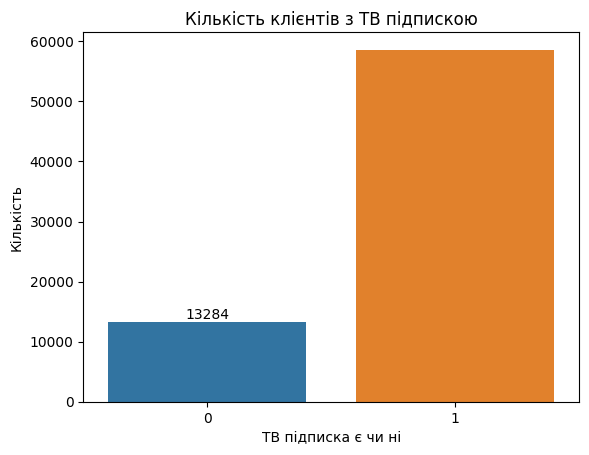

time: 1.17 s (started: 2024-10-18 16:15:44 +00:00)


In [28]:
plt.title("Кількість клієнтів з ТВ підпискою")
ax = sns.countplot(x='is_tv_subscriber', data=df, palette="tab10")
ax.set(xlabel="ТВ підписка є чи ні")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

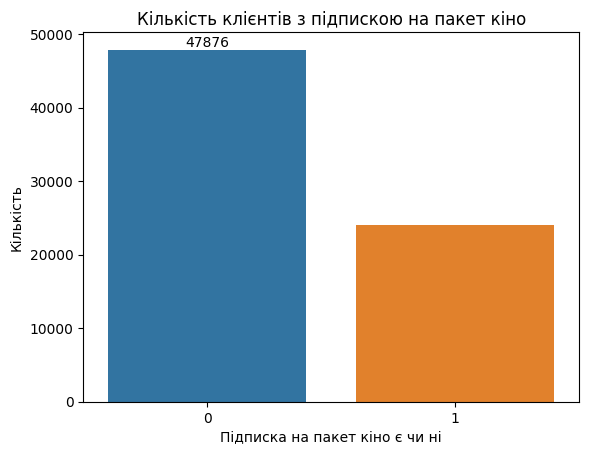

time: 919 ms (started: 2024-10-18 16:15:45 +00:00)


In [29]:
plt.title("Кількість клієнтів з підпискою на пакет кіно")
ax = sns.countplot(x='is_movie_package_subscriber', data=df, palette="tab10")
ax.set(xlabel="Підписка на пакет кіно є чи ні")
ax.set(ylabel="Кількість")
ax.bar_label(ax.containers[0])
plt.show()

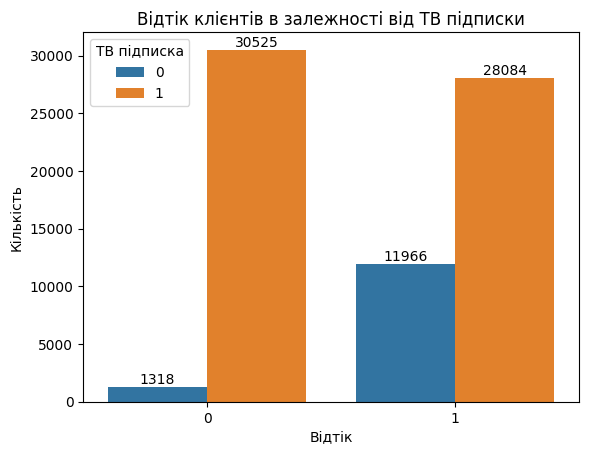

time: 1.52 s (started: 2024-10-18 16:15:46 +00:00)


In [30]:
plt.title("Відтік клієнтів в залежності від ТВ підписки")
ax = sns.countplot(x='churn', data=df, hue="is_tv_subscriber")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="ТВ підписка")
plt.show()

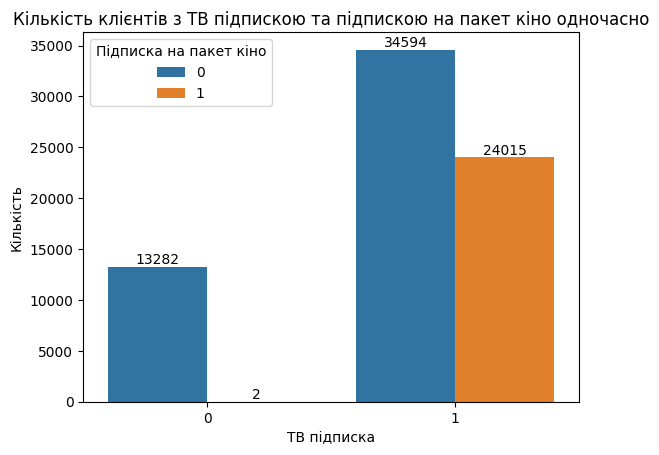

time: 1.46 s (started: 2024-10-18 16:15:47 +00:00)


In [31]:
plt.title("Кількість клієнтів з ТВ підпискою та підпискою на пакет кіно одночасно")
ax = sns.countplot(x='is_tv_subscriber', data=df, hue="is_movie_package_subscriber")
ax.set(xlabel="ТВ підписка")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Підписка на пакет кіно")
plt.show()

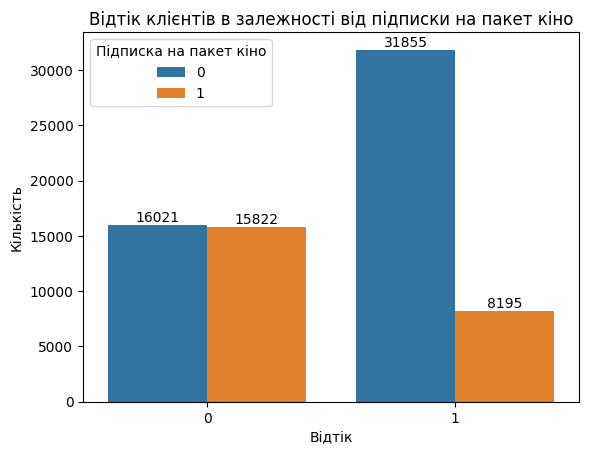

time: 797 ms (started: 2024-10-18 16:15:49 +00:00)


In [32]:
plt.title("Відтік клієнтів в залежності від підписки на пакет кіно")
ax = sns.countplot(x='churn', data=df, hue="is_movie_package_subscriber")
ax.set(xlabel="Відтік")
ax.set(ylabel="Кількість")
for container in ax.containers:
    ax.bar_label(container)
plt.legend(title="Підписка на пакет кіно")
plt.show()

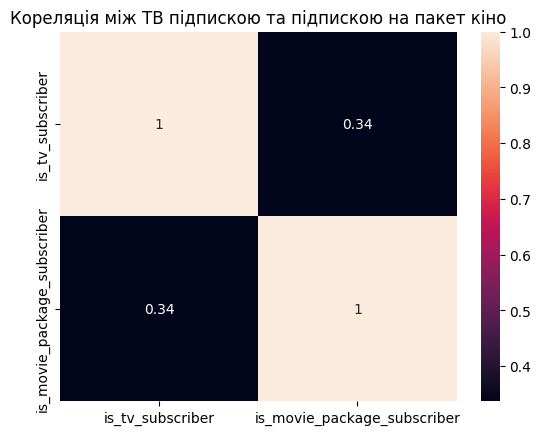

time: 435 ms (started: 2024-10-18 16:15:50 +00:00)


In [33]:
plt.title("Кореляція між ТВ підпискою та підпискою на пакет кіно")
ax = sns.heatmap(df[['is_tv_subscriber', 'is_movie_package_subscriber']].corr(), annot=True)
plt.show()

### Висновок

По ТВ підписці (is_tv_subscriber=1):

* Кількість клієнтів з ТВ підпискою набагато більша, ніж без неї
* Клієнти з активною ТВ підпискою більше схильні до відтоку

Тобто: цей параметр <u>важливий</u> для аналізу

По підписці на пакет кіно (is_movie_package_subscriber=1):

* Клієнтів з активною підпискою на пакет кіно набагато меньше ніж без неї
* Підписка на пакет кіно сильно залежить від ТВ підписки

Тобто: цей параметр <u>не важливий</u> для аналізу


Також спостерігається кореляція між цими двома категріями

## Аналіз залежності відтоку клієнтів від об'єму трафіку

(download_avg, upload_avg)

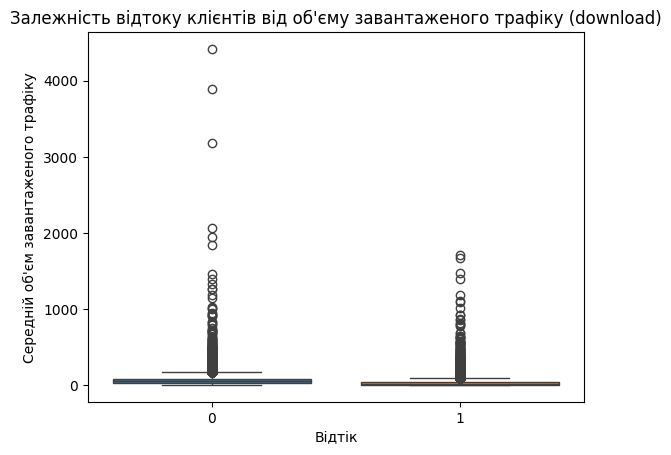

time: 814 ms (started: 2024-10-18 16:15:50 +00:00)


In [34]:
plt.title("Залежність відтоку клієнтів від об'єму завантаженого трафіку (download)")
ax = sns.boxplot(x='churn', y='download_avg', data=df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Середній об'єм завантаженого трафіку")
plt.show()

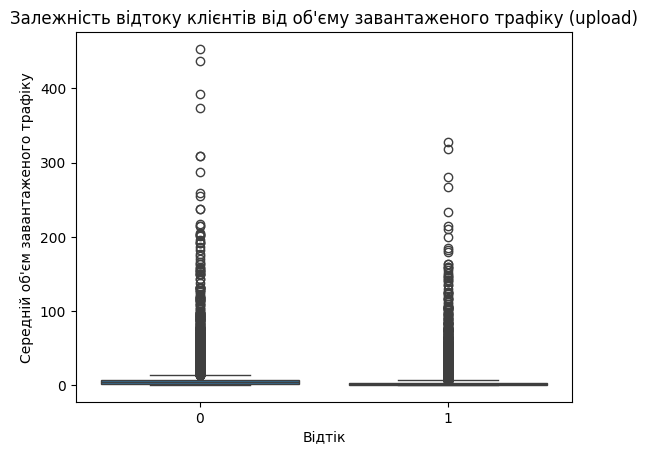

time: 786 ms (started: 2024-10-18 16:15:51 +00:00)


In [35]:
plt.title("Залежність відтоку клієнтів від об'єму завантаженого трафіку (upload)")
ax = sns.boxplot(x='churn', y='upload_avg', data=df, palette="tab10")
ax.set(xlabel="Відтік")
ax.set(ylabel="Середній об'єм завантаженого трафіку")
plt.show()

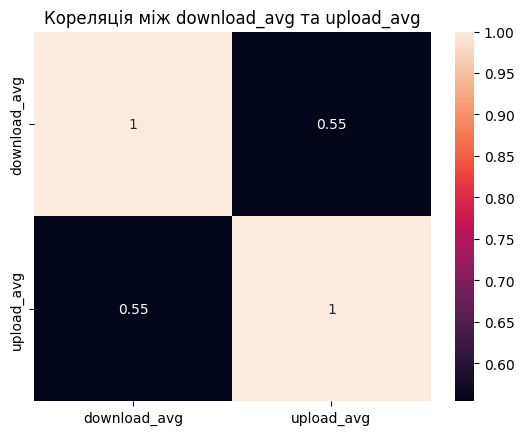

time: 544 ms (started: 2024-10-18 16:15:52 +00:00)


In [36]:
plt.title("Кореляція між download_avg та upload_avg")
ax = sns.heatmap(df[['download_avg', 'upload_avg']].corr(), annot=True)
plt.show()

### Висновок

* Об'єм завантаженого трафіку (як download_avg так і upload_avg) не сильно впливає на відтік.
* Спостерігається кореляція між цими двома категріями
* Клієнти зі значним об'ємом завантаженого трафіку (як download_avg так і upload_avg) меньш схильні до відтоку, але їх кількість занадто мала, щоб враховувати це як окремий фактор.


## Додаткова перевірка

In [37]:
from sklearn.feature_selection import mutual_info_classif
x = df.drop(columns=["churn"])
y = df["churn"]
important_features = mutual_info_classif(x, y, random_state=SEED)

time: 12.8 s (started: 2024-10-18 16:15:52 +00:00)


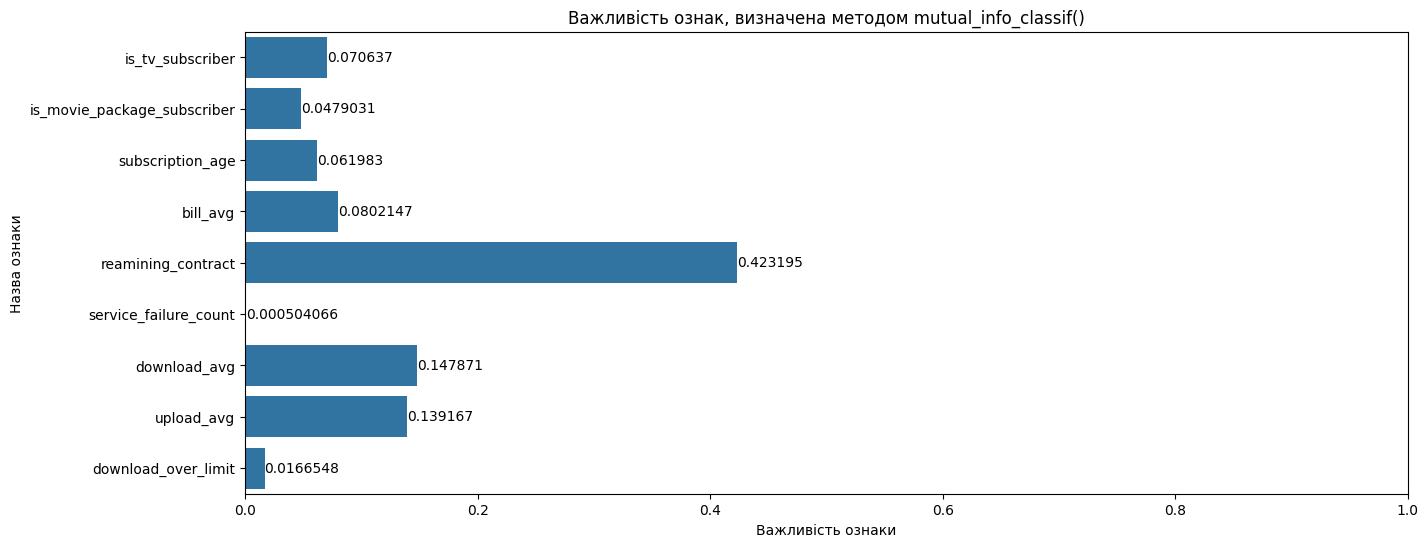

time: 669 ms (started: 2024-10-18 16:16:05 +00:00)


In [38]:
plt.figure(figsize=(15,6))
ax = sns.barplot(important_features, orient ='h')
ax.set(xlabel="Важливість ознаки", ylabel="Назва ознаки")
ax.set_xlim(0, 1)
ax.set_yticklabels(x.columns)
ax.bar_label(ax.containers[0])
ax.set_title("Важливість ознак, визначена методом mutual_info_classif()")
plt.show()

In [39]:
from sklearn.feature_selection import SelectKBest

best_features = SelectKBest(k="all")
fit = best_features.fit(df.drop(columns=["churn"]), df["churn"])

time: 56.2 ms (started: 2024-10-18 16:16:06 +00:00)


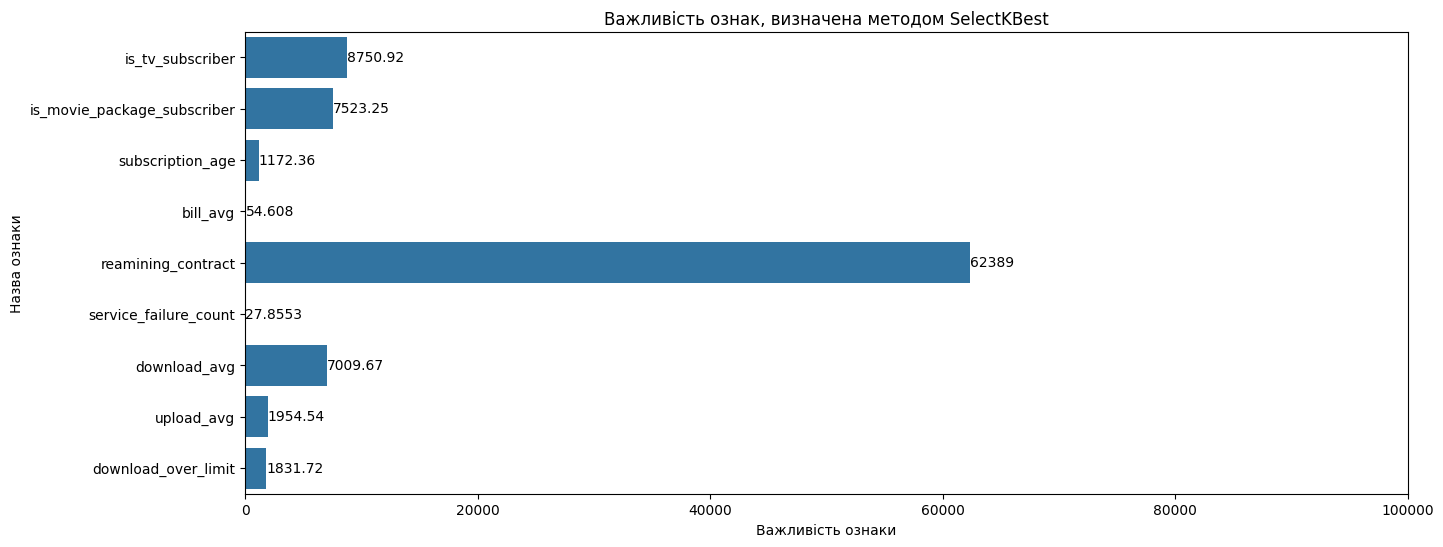

time: 720 ms (started: 2024-10-18 16:16:06 +00:00)


In [40]:
plt.figure(figsize=(15,6))
ax = sns.barplot(fit.scores_, orient ='h')
ax.set(xlabel="Важливість ознаки", ylabel="Назва ознаки")
ax.set_xlim(0, 100000)
ax.set_yticklabels(x.columns)
ax.bar_label(ax.containers[0])
ax.set_title("Важливість ознак, визначена методом SelectKBest")
plt.show()

time: 740 ms (started: 2024-10-18 16:16:06 +00:00)


## Висновок

**Важливими** ознаками для прогнозування відтоку клієнтів є:
* reamining_contract
* is_tv_subscriber

**Неважливими** ознаками для прогнозування відтоку клієнтів є:


*   service_failure_count
*   download_over_limit

Неважливими ознаками можна знехтувати.



In [41]:
df.drop(columns=['service_failure_count', 'download_over_limit'], inplace=True)

time: 8.12 ms (started: 2024-10-18 16:16:07 +00:00)


In [42]:
df


,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,download_avg,upload_avg,churn
0,1,0,11.95,25,0.14,8.4,2.3,0
1,0,0,8.22,0,0.00,0.0,0.0,1
2,1,0,8.91,16,0.00,13.7,0.9,1
3,0,0,6.87,21,0.00,0.0,0.0,1
4,0,0,6.39,0,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...
72269,1,1,0.09,0,1.25,0.0,0.0,1
72270,1,0,0.06,1,1.63,0.8,0.0,1
72271,1,0,0.02,0,2.19,1.5,0.2,1
72272,0,0,0.01,0,0.72,0.0,0.0,1


time: 158 ms (started: 2024-10-18 16:16:07 +00:00)


## Пошук викидів (outliers)

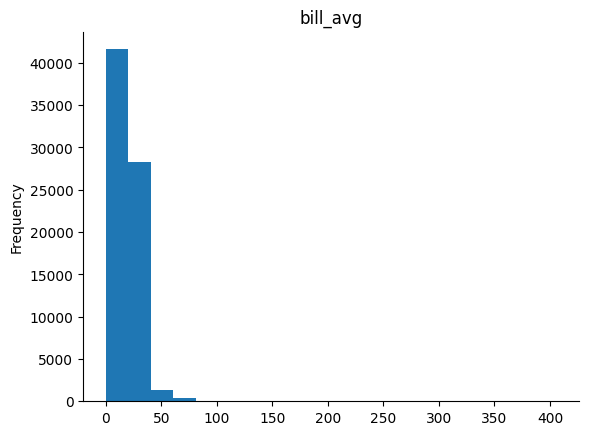

time: 1.05 s (started: 2024-10-18 16:16:07 +00:00)


In [43]:
from matplotlib import pyplot as plt
df['bill_avg'].plot(kind='hist', bins=20, title='bill_avg')
plt.gca().spines[['top', 'right',]].set_visible(False)

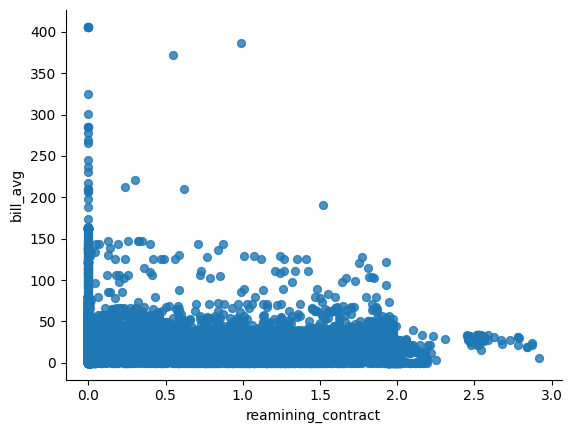

time: 1.43 s (started: 2024-10-18 16:16:08 +00:00)


In [44]:
df.plot(kind='scatter', y='bill_avg', x='reamining_contract', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

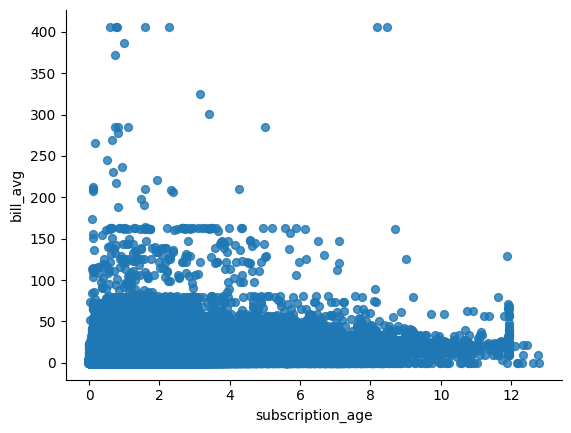

time: 1.45 s (started: 2024-10-18 16:16:09 +00:00)


In [45]:
df.plot(kind='scatter', x='subscription_age', y='bill_avg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [46]:
# відсоток аутлеєрів по ознаці 'bill_avg' > 100
bill_avg_outliers = df[df['bill_avg'] > 300]
bill_avg_outliers_percent = bill_avg_outliers.shape[0] / df.shape[0] * 100
print(f"Відсоток аутлеєрів по ознаці 'bill_avg': {bill_avg_outliers_percent:.2f}%")

Відсоток аутлеєрів по ознаці 'bill_avg': 0.02%
time: 36.4 ms (started: 2024-10-18 16:16:11 +00:00)


In [47]:
bill_avg_outliers

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,download_avg,upload_avg,churn
2705,0,0,8.47,406,0.00,2058.1,131.0,0
3603,0,0,8.18,406,0.00,458.5,131.0,0
38611,1,0,3.41,301,0.00,203.2,204.2,0
40654,0,0,3.15,325,0.00,246.2,86.7,0
48343,0,0,2.28,406,0.00,1026.2,128.5,0
54773,0,0,1.59,406,0.00,3890.8,165.6,0
60786,1,0,0.99,386,0.99,225.6,60.3,0
63091,0,0,0.80,406,0.00,133.8,37.8,0
63313,0,0,0.78,406,0.00,1008.7,99.1,0
63649,1,1,0.75,372,0.55,4415.2,202.3,0


time: 92 ms (started: 2024-10-18 16:16:11 +00:00)


In [48]:
# Видяляємо дані з аутлеєрами
df.drop(bill_avg_outliers.index, inplace=True)

time: 27.5 ms (started: 2024-10-18 16:16:11 +00:00)


In [49]:
df

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,download_avg,upload_avg,churn
0,1,0,11.95,25,0.14,8.4,2.3,0
1,0,0,8.22,0,0.00,0.0,0.0,1
2,1,0,8.91,16,0.00,13.7,0.9,1
3,0,0,6.87,21,0.00,0.0,0.0,1
4,0,0,6.39,0,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...
72269,1,1,0.09,0,1.25,0.0,0.0,1
72270,1,0,0.06,1,1.63,0.8,0.0,1
72271,1,0,0.02,0,2.19,1.5,0.2,1
72272,0,0,0.01,0,0.72,0.0,0.0,1


time: 155 ms (started: 2024-10-18 16:16:11 +00:00)


In [50]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,71882.0,0.815308,0.388050,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,71882.0,0.334103,0.471679,0.00,0.00,0.00,1.00,1.00
subscription_age,71882.0,2.455431,2.026719,-0.02,0.94,1.98,3.30,12.80
bill_avg,71882.0,18.960964,12.383929,0.00,13.00,19.00,22.00,285.00
reamining_contract,71882.0,0.497667,0.665780,0.00,0.00,0.00,1.03,2.92
download_avg,71882.0,43.492609,58.734734,0.00,6.70,27.80,60.40,3179.80
upload_avg,71882.0,4.174503,9.693839,0.00,0.50,2.10,4.80,453.30
churn,71882.0,0.557163,0.496725,0.00,0.00,1.00,1.00,1.00


time: 876 ms (started: 2024-10-18 16:16:11 +00:00)


#  Зберігання оброблених даних

In [51]:
df.to_csv(MODELS_PATH/'processed_dataset.csv', index=False)

time: 1.3 s (started: 2024-10-18 16:16:12 +00:00)
